In [1]:
#imports

import at3d
import numpy as np
import xarray as xr
from collections import OrderedDict
import pylab as py
np.random.seed(1)

In [2]:
sensors, solvers, rte_grid = at3d.util.load_forward_model('./SimulateRadiances.nc')

# Perform some cloud masking using a single fixed threshold based on the observation that 
# everywhere else will be very dark.
sensor_list = []
for sensor in sensors['MSPI']['sensor_list']:
    copied = sensor.copy(deep=True)
    weights = np.zeros(sensor.sizes['nrays'])
    ray_mask =np.zeros(sensor.sizes['nrays'], dtype=int)
    
    ray_mask_pixel = np.zeros(sensor.npixels.size, dtype=int)
    
    # I have not optimized this threshold whatsoever.
    # Feel free to experiment with the cloud mask threshold. 
    # You can compare the observations
    # with a visualization of the initial_state to evaluate the mask.
    # or look at at3d.space_carve.SpaceCarver.project
    ray_mask_pixel[np.where(sensor.I.data > 2e-3)] = 1
    copied['weights'] = ('nrays',sensor.I.data)
    copied['cloud_mask'] = ('nrays', ray_mask_pixel[sensor.pixel_index.data])
    sensor_list.append(copied)

space_carver = at3d.space_carve.SpaceCarver(rte_grid, 3) # 3 means open boundary in both dimensions
carved_volume = space_carver.carve(sensor_list, agreement=(0.0, 1.0), linear_mode=False)

# remove cloud mask values at outer boundaries to prevent interaction with open boundary conditions.
carved_volume.mask[0] = carved_volume.mask[-1] =carved_volume.mask[:,0] =carved_volume.mask[:,-1] = 0.0
        

In [3]:
# make forward_sensors which will hold synthetic measurements from the evaluation of the forward model.
forward_sensors = sensors.make_forward_sensors()

# add an uncertainty model to the observations.
uncertainty = at3d.uncertainties.NullUncertainty('L2',1e8)
sensors.add_uncertainty_model('MSPI', uncertainty)

# prepare all of the static inputs to the solver just copy pasted from forward model
surfaces = OrderedDict()
numerical_parameters = OrderedDict()
sources = OrderedDict()
num_stokes = OrderedDict()
background_optical_scatterers = OrderedDict()
for key in forward_sensors.get_unique_solvers():
    surfaces[key] = solvers[key].surface
    numerical_params = solvers[key].numerical_params
    #numerical_params['num_mu_bins'] = 2
    #numerical_params['num_phi_bins'] = 4
    numerical_parameters[key] = numerical_params
    sources[key] = solvers[key].source
    num_stokes[key] = solvers[key]._nstokes
    background_optical_scatterers[key] = {'rayleigh': solvers[key].medium['rayleigh']}


In [4]:
mie_mono_tables = OrderedDict()
for wavelength in sensors.get_unique_solvers():
    mie_mono_tables[wavelength] = at3d.mie.get_mono_table(
        'Water',(wavelength,wavelength),
        max_integration_radius=65.0,
        minimum_effective_radius=0.1,
        relative_dir='../mie_tables',
        verbose=False
    )
size_distribution_function = at3d.size_distribution.gamma
optical_property_generator = at3d.medium.OpticalPropertyGenerator(
    'cloud', 
    mie_mono_tables,
    size_distribution_function,
    reff=np.linspace(.1,30.0,30),
    veff=np.linspace(0.03,0.2,9),
)

optical_properties = solvers[0.66].medium['cloud'].copy(deep=True)
optical_properties = optical_properties.drop_vars('extinction')
optical_properties = optical_properties.drop_vars('reff')

# optical_properties_swir = solvers[2.13].medium['cloud'].copy(deep=True)
# optical_properties_swir = optical_properties_swir.drop_vars('extinction')
# optical_properties_swir = optical_properties_swir.drop_vars('reff')

In [5]:
# We are using the ground_truth rte_grid.
dataset = rte_grid.copy(deep=True)
#dataset['density'] = solvers[.66].medium['cloud'].density
#dataset = dataset.reset_coords(['veff'], drop=True)
dataset["veff"] = solvers[.66].medium['cloud'].veff
dataset = dataset.reset_coords(['reff'], drop=True)
print(dataset)
micro_grid_to_optical_properties = at3d.medium.MicrophysicsGridToOpticalProperties(
    rte_grid, optical_property_generator, dataset#optical_properties
    #reff = (np.zeros(rte_grid.grid.shape)+ 0.0, np.zeros(rte_grid.grid.shape) + 30)
)
grid_to_optical_properties = at3d.medium.GridToOpticalProperties(
    rte_grid,'cloud2', 0.66,optical_properties
)

<xarray.Dataset>
Dimensions:  (x: 32, y: 37, z: 27)
Coordinates:
  * x        (x) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.54 0.56 0.58 0.6 0.62
  * y        (y) float64 0.0 0.02 0.04 0.06 0.08 0.1 ... 0.64 0.66 0.68 0.7 0.72
  * z        (z) float64 0.0 0.44 0.48 0.52 0.56 0.6 ... 1.28 1.32 1.36 1.4 1.44
Data variables:
    delx     float64 0.02
    dely     float64 0.02
    veff     (x, y, z) float64 ...
OrderedDict([('extinction', (array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..

In [6]:
relative_scaling_reff = 1
relative_scaling_lwc = 1
unknown_scatterers = at3d.containers.UnknownScatterers(
    at3d.medium.UnknownScatterer(micro_grid_to_optical_properties,
    reff=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].reff.data), relative_scaling_reff * 1.0/np.std(solvers[.66].medium['cloud'].reff.data)), at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    density=(at3d.transforms.CoordinateTransformScaling(np.mean(solvers[.66].medium['cloud'].density.data), relative_scaling_lwc * 1.0/np.std(solvers[.66].medium['cloud'].density.data)), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    # reff=(None, at3d.transforms.StateToGridProfile(mask=carved_volume.mask.data)),
    # density=(None, at3d.transforms.StateToGridMask(mask=carved_volume.mask.data))
    ),
    # at3d.medium.UnknownScatterer(grid_to_optical_properties,
    # extinction=(at3d.transforms.CoordinateTransformScaling(0, .01), at3d.transforms.StateToGridMask(mask=carved_volume.mask.data)))
)

In [7]:
# now we form state_gen which updates the solvers with an input_state.
solvers_reconstruct = at3d.containers.SolversDict()

state_gen = at3d.medium.StateGenerator(solvers_reconstruct,
                                         unknown_scatterers, surfaces,
                                         numerical_parameters, sources, background_optical_scatterers,
                                         num_stokes)

In [8]:
# get bounds automatically.
min_bounds, max_bounds = state_gen.transform_bounds()

In [9]:
# transform initial physical state to abstract state. 
initial_gridded_reff = carved_volume.mask.data.astype(float)*10.0
initial_1d_reff = state_gen._unknown_scatterers['cloud'].variables['reff'].state_to_grid.inverse_transform(initial_gridded_reff)
initial_gridded_density = carved_volume.mask.data.astype(float)*0.0
initial_1d_density = state_gen._unknown_scatterers['cloud'].variables['density'].state_to_grid.inverse_transform(initial_gridded_density)
x0 = np.concatenate((state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff), 
                    state_gen._unknown_scatterers['cloud'].variables['density'].coordinate_transform.inverse_transform(initial_1d_density)
                    ), axis=0)
#x0 = state_gen._unknown_scatterers['cloud'].variables['reff'].coordinate_transform.inverse_transform(initial_1d_reff)


In [10]:
objective_function = at3d.optimize.ObjectiveFunction.LevisApproxUncorrelatedL2(
    sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, state_gen,
  state_gen.project_gradient_to_state,
    parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
  gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
  uncertainty_kwargs={'add_noise': False},
  min_bounds=min_bounds, max_bounds=max_bounds)

In [11]:
%matplotlib inline
def plot(optimizer):
    fig, axs = py.subplots(1, 2, figsize=(12, 3))  # Create a figure with subplots side by side
    # axs[0].plot(solvers_reconstruct[0.66].medium['cloud2'].extinction.data.ravel(), 
    #         solvers[0.66].medium['cloud'].extinction.data.ravel(),'x')
    # axs[0].plot([0,130],[0,130])
    axs[1].plot(solvers_reconstruct[0.66].medium['cloud'].density.data.ravel(), 
            solvers[0.66].medium['cloud'].density.data.ravel(),'x')
    axs[1].plot([0,2],[0,2])
    axs[0].plot(solvers_reconstruct[0.66].medium['cloud'].reff.data.ravel(), 
            solvers[0.66].medium['cloud'].reff.data.ravel(),'x')
    axs[0].plot([10,20],[10,20])
    #axs[3].plot(solvers_reconstruct[2.13].medium['cloud'].reff.data.ravel(), 
            #solvers[2.13].medium['cloud'].reff.data.ravel(),'x')
    #axs[3].plot([0,30],[0,30])
    # loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
    #         sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
    #         gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
    #         uncertainty_kwargs={'add_noise': False})()
    grads = optimizer.objective(optimizer._state)[1]
    print(grads.mean())
    print(grads.std())
    py.show()
    return {'None': None}
callback = at3d.callback.CallbackFn(plot)

In [12]:
grads = objective_function(x0)[1]
print(grads.mean())
print(grads.std())

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
-474.96444373016953
318.68754780711043


  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]


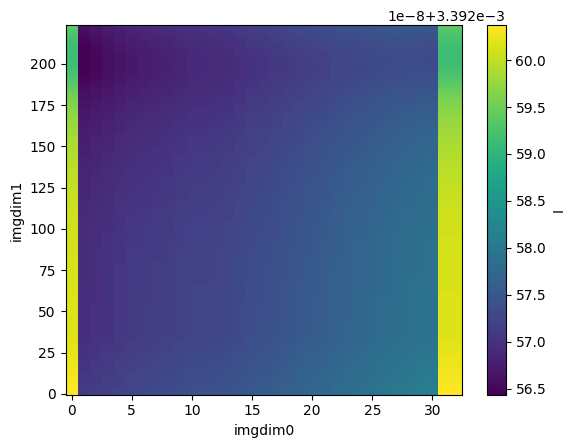

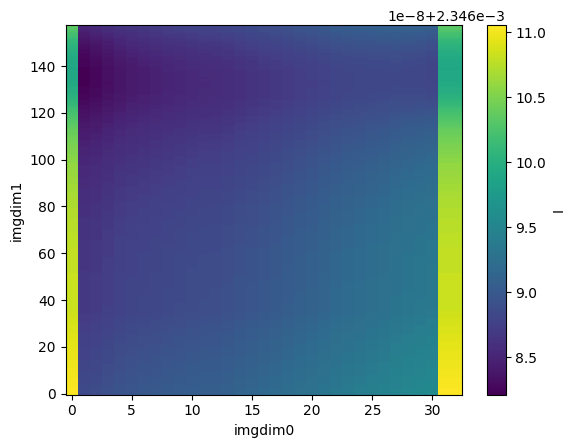

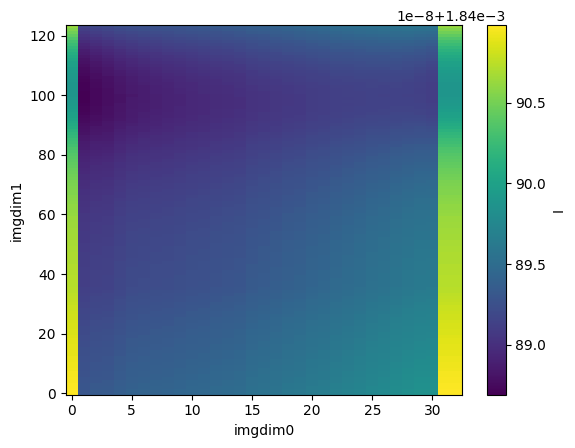

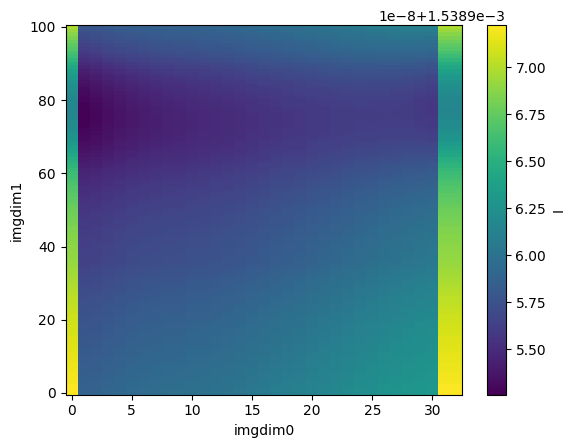

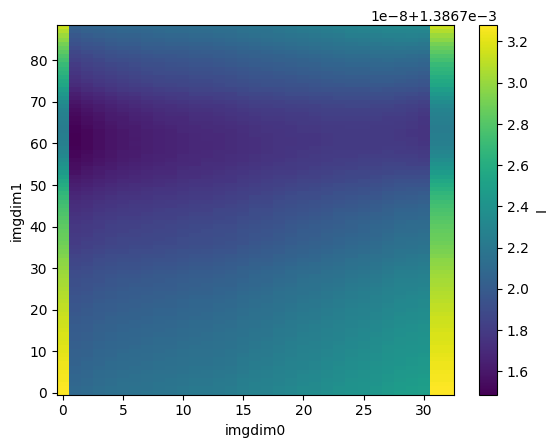

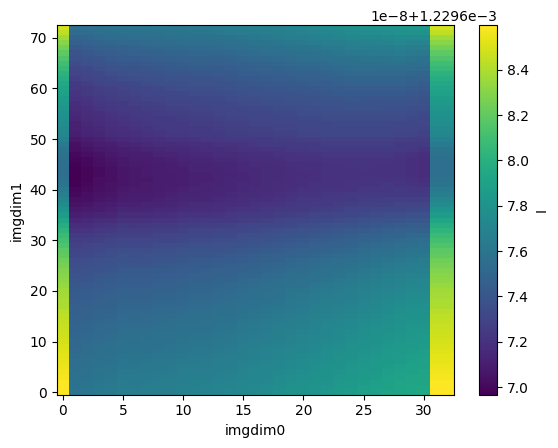

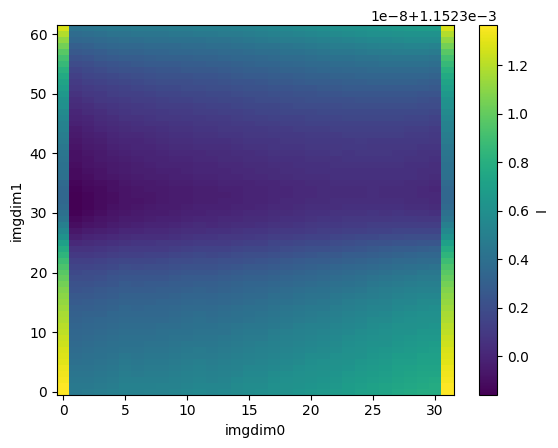

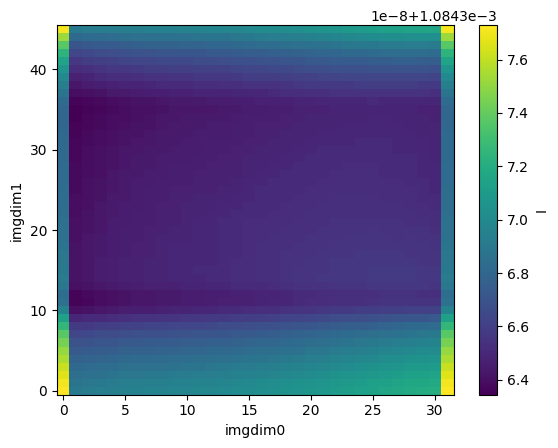

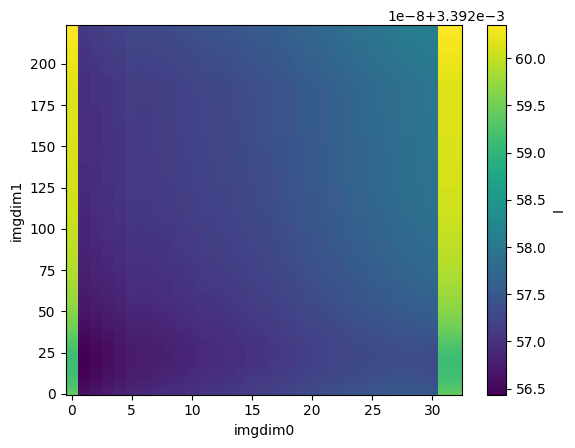

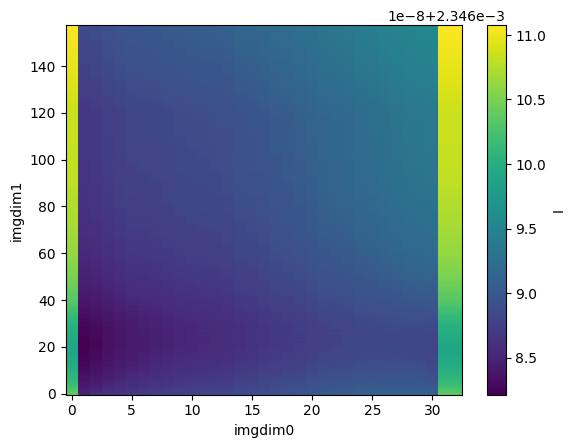

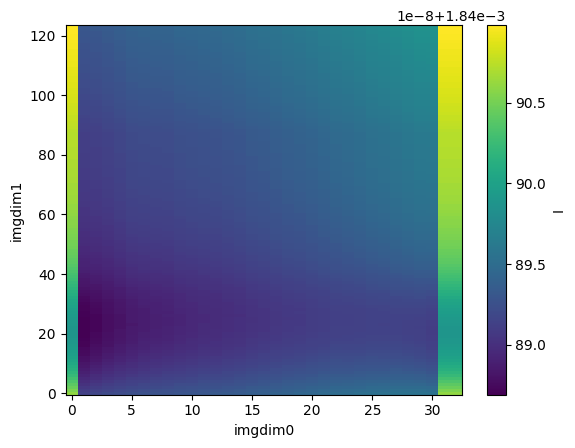

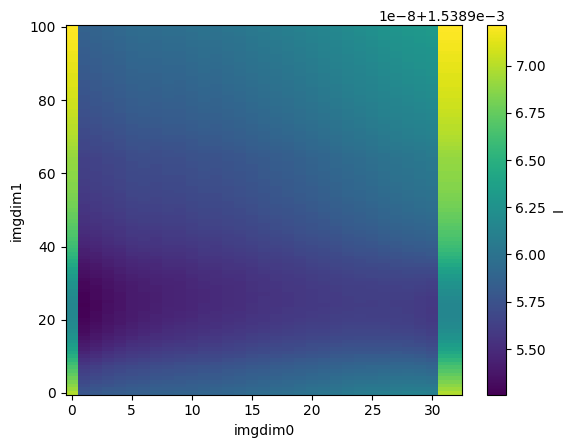

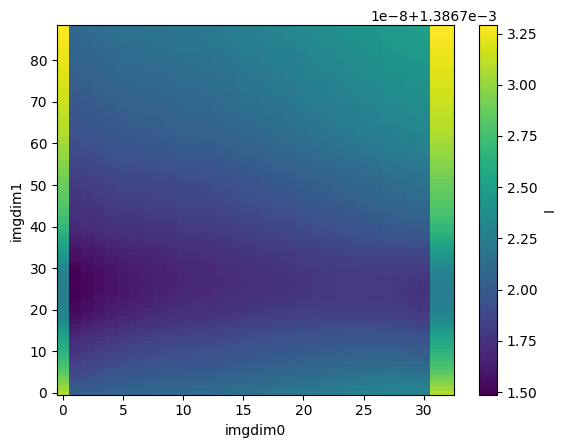

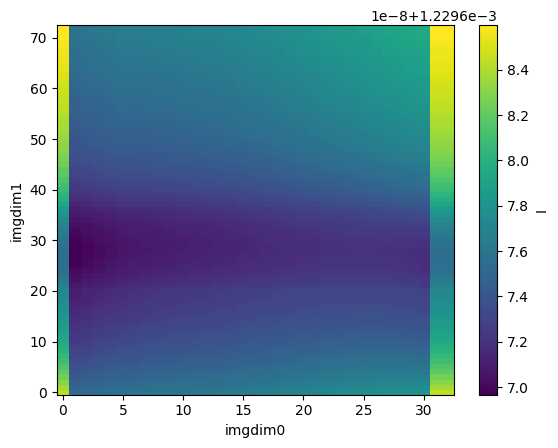

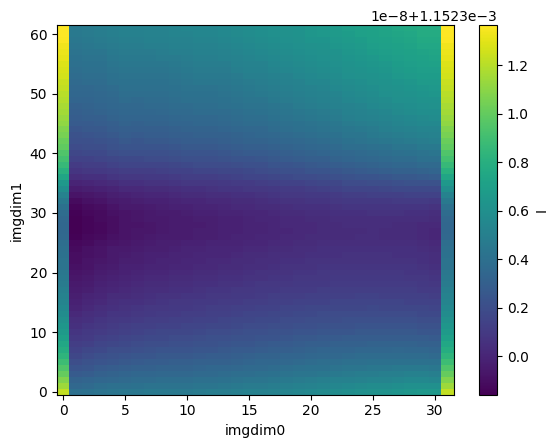

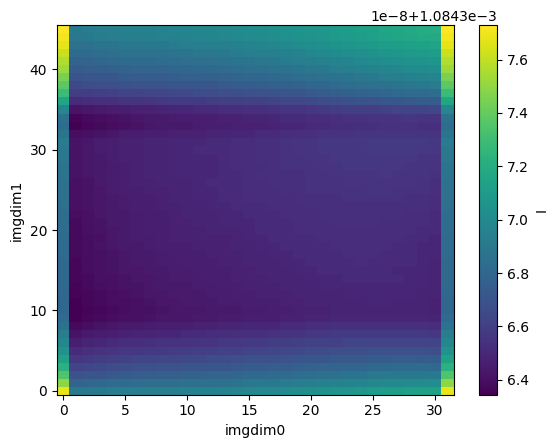

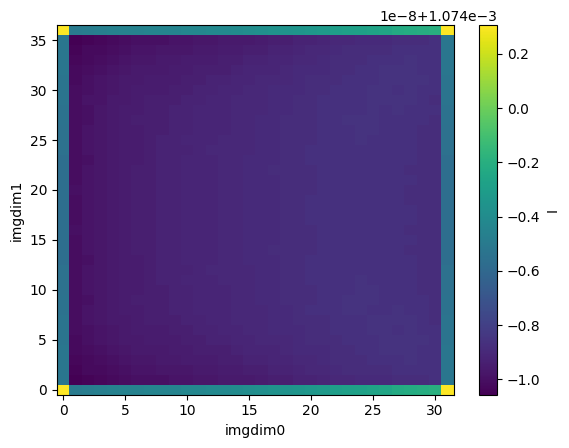

In [13]:
state_gen(x0)
#visualize the initial state
forward_sensors.get_measurements(solvers_reconstruct)

for instrument in forward_sensors:
    for im in forward_sensors.get_images(instrument):
        py.figure()
        im.I.T.plot()

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -2.238  0.149E-04    31968     9.00  0.035   [Radiance 0.660 micron]
     2  -4.100  0.150E-04    31968     9.00  0.035   [Radiance 0.660 micron]
 ! Iterations:      2     Final Criterion:  0.000079   [Radiance 0.660 micron]
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         9064     M =           10

At X0      9037 variables are exactly at the bounds

At iterate    0    f=  5.89971D+04    |proj g|=  7.83097D+02
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.571  0.544E+00    31968    26.50  0.104   [Radiance 0.660 micron]
     2  -2.000  0.542E+00    31968    35.31  0.138   [Radiance 0.660 micron]
     3  -1.939  0.413E+00    32625    51.02  0.199   [Radiance 0.660 micron]
     4  -1.514  0.194E+00    50251   115.52  0.451   [Radiance 0.660 micron]
     5  -1.253  0.194E+00    56455   131.06  0.512   [Radiance 0.660 micron]
     

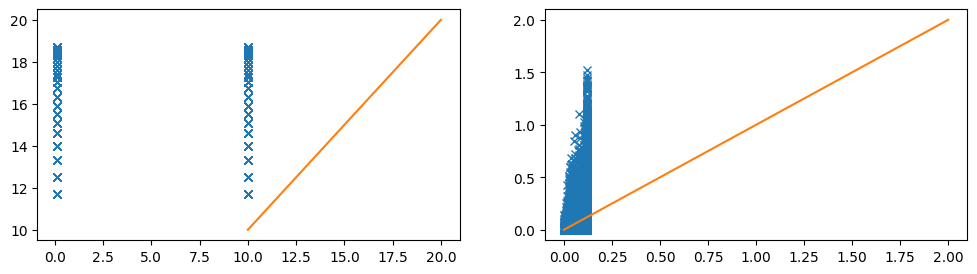

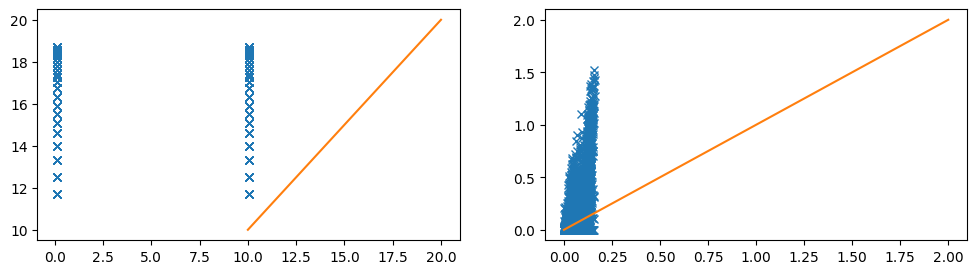

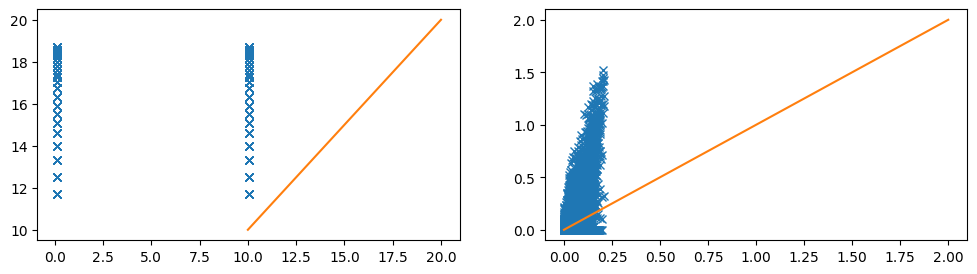

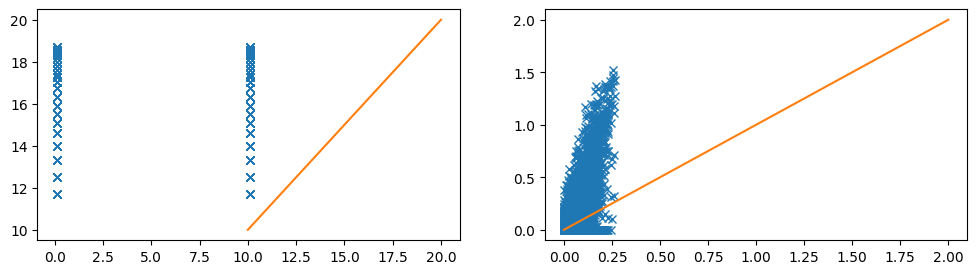

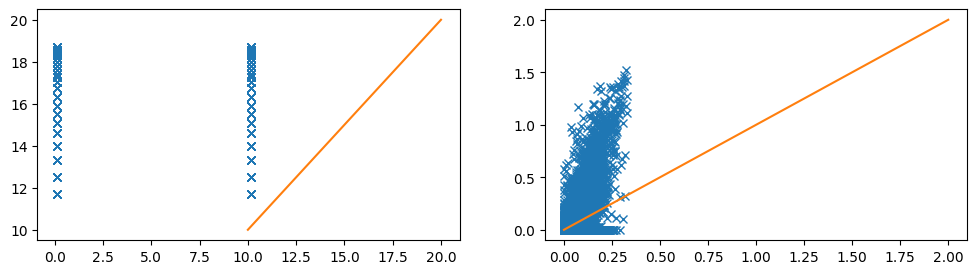

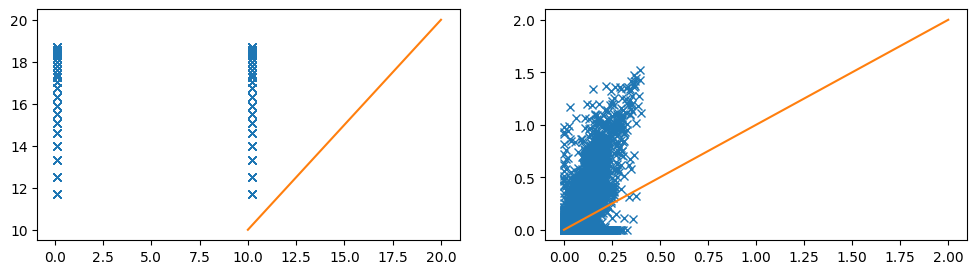

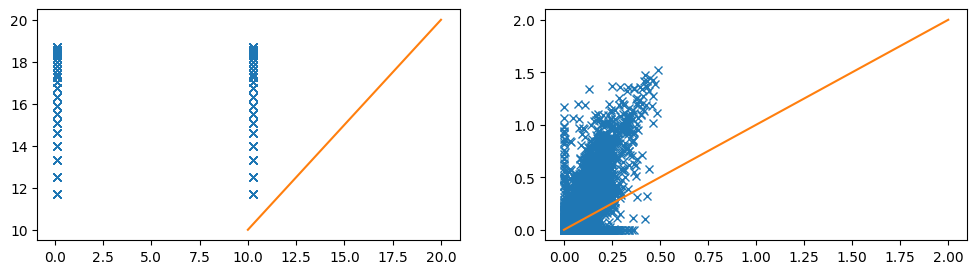

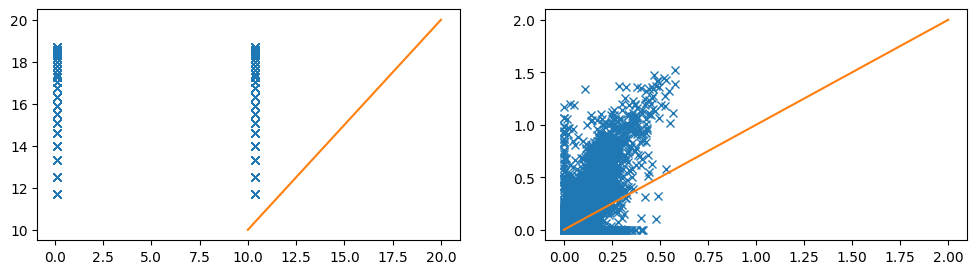

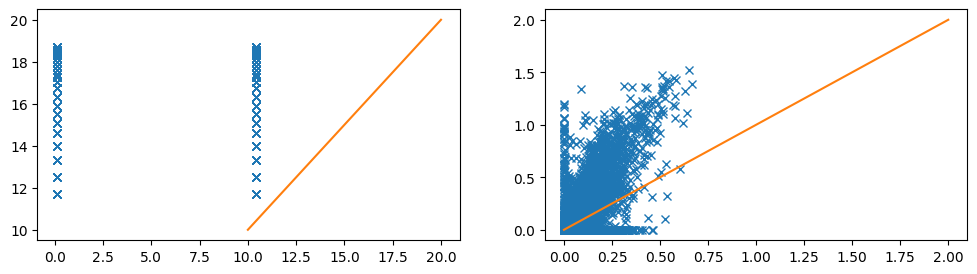

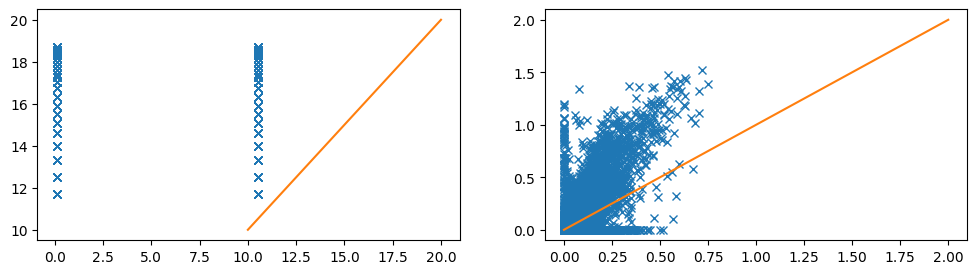

In [14]:
import warnings
optimizer = at3d.optimize.Optimizer(objective_function,callback_fn=callback, options={'maxiter': 100, 'maxls': 10, 'disp': True})
warnings.filterwarnings('ignore')
optimizer._options['maxiter'] = 10
result = optimizer.minimize(x0)

  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.681  0.312E+00    31968    61.97  0.242   [Radiance 0.660 micron]
     2  -1.229  0.343E+00    31968    61.97  0.242   [Radiance 0.660 micron]
     3  -1.633  0.357E+00    31968    61.97  0.242   [Radiance 0.660 micron]
     4  -1.923  0.243E+00    32081    62.63  0.245   [Radiance 0.660 micron]
     5  -2.363  0.139E+00    32506    64.83  0.253   [Radiance 0.660 micron]
     6  -2.365  0.733E-01    35023    77.29  0.302   [Radiance 0.660 micron]
     7  -2.431  0.532E-01    37880    89.57  0.350   [Radiance 0.660 micron]
     8  -2.569  0.430E-01    40717   100.10  0.391   [Radiance 0.660 micron]
     9  -2.634  0.346E-01    44946   113.45  0.443   [Radiance 0.660 micron]
    10  -2.734  0.300E-01    48639   123.14  0.481   [Radiance 0.660 micron]
    11  -3.037  0.300E-01    48760   123.42  0.482   [Radiance 0.660 micron]
    12  -3.279  0.301E-01    48760   123.42  0.482   [Radiance 0.660 micron]
  

{'None': None}

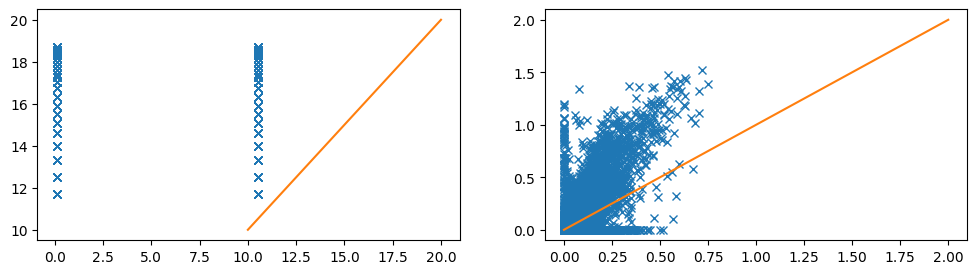

In [15]:
plot(optimizer)

In [16]:
print(solvers_reconstruct)

SolversDict([(0.66, <at3d.solver.RTE object at 0x7ff2a085bc40>)])


In [17]:
# final_state = state_gen.get_state()
# import warnings
# warnings.filterwarnings('ignore')
# optimizer._options['maxiter'] = 10
# result = optimizer.minimize(final_state)

In [18]:
unknown_scatterer_indices = list(solvers_reconstruct.values())[0]._unknown_scatterer_indices - 1
unknown_scatterer_names = np.array(list(list(solvers_reconstruct.values())[0].medium.keys()))[unknown_scatterer_indices]
print(unknown_scatterer_names)
#print(objective_function(state_gen.get_state())[0].shape)
grads = (objective_function(state_gen.get_state())[1])

['cloud' 'cloud']
  ! Iter Log(Sol)  SplitCrit  Npoints  Nsh(avg)   [Radiance 0.660 micron]
     1  -0.681  0.312E+00    31968    61.97  0.242   [Radiance 0.660 micron]
     2  -1.229  0.343E+00    31968    61.97  0.242   [Radiance 0.660 micron]
     3  -1.633  0.357E+00    31968    61.97  0.242   [Radiance 0.660 micron]
     4  -1.923  0.243E+00    32081    62.63  0.245   [Radiance 0.660 micron]
     5  -2.363  0.139E+00    32506    64.83  0.253   [Radiance 0.660 micron]
     6  -2.365  0.733E-01    35023    77.29  0.302   [Radiance 0.660 micron]
     7  -2.431  0.532E-01    37880    89.57  0.350   [Radiance 0.660 micron]
     8  -2.569  0.430E-01    40717   100.10  0.391   [Radiance 0.660 micron]
     9  -2.634  0.346E-01    44946   113.45  0.443   [Radiance 0.660 micron]
    10  -2.734  0.300E-01    48639   123.14  0.481   [Radiance 0.660 micron]
    11  -3.037  0.300E-01    48760   123.42  0.482   [Radiance 0.660 micron]
    12  -3.279  0.301E-01    48760   123.42  0.482   [Radianc

In [19]:
print(grads[9000:])

[ 1.66499732  0.94602576  0.83314892 -5.23245293  2.95791517  0.94566745
  1.53675103  1.3941032   0.92478996  0.75990338  3.36464069 -6.03527068
  1.3661356   1.36161523  1.42060381  1.53110338  2.10003306  3.91349951
  3.03941181  1.21174892  1.39617385  2.49770292  3.6915565   4.19516657
 -4.2670763   2.663547    3.6406875   0.1553019   0.67257667  0.30945308
 -0.15500864 -0.10602359  0.64786337  0.28443838  0.0402086  -0.17932815
 -0.31218905  0.28701649  0.20272076 -0.06141665 -0.14255517 -0.16170294
 -0.14686548  0.15776733  0.19239202 -0.0193107  -0.17018846 -0.16624445
 -0.03304299  0.13742273  0.09186483 -0.06517638 -0.13878661 -0.16895738
 -0.01363717  0.15019722 -0.00995422 -0.17550007  0.02902244  0.16691086
 -0.01208551 -0.18415051 -0.04679699 -0.10357479]


In [20]:
loss, gradient, _ = at3d.gradient.LevisApproxGradientUncorrelated(
            sensors, solvers_reconstruct, forward_sensors, unknown_scatterers, parallel_solve_kwargs={'n_jobs': 4, 'verbose': True},
            gradient_kwargs={'cost_function': 'L2', 'exact_single_scatter':True},
            uncertainty_kwargs={'add_noise': False})()
print(gradient["gradient"][:,:,:,0].std())
print(gradient["gradient"][:,:,:,0].mean())
print(gradient["gradient"][:,:,:,1].max())
print(gradient["gradient"][:,:,:,1].std())

<xarray.DataArray 'gradient' ()>
array(0.0139548)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'reff')
<xarray.DataArray 'gradient' ()>
array(0.00018344)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'reff')
<xarray.DataArray 'gradient' ()>
array(17204.07011409)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'density')
<xarray.DataArray 'gradient' ()>
array(542.00357756)
Coordinates:
    wavelength        float64 0.66
    derivative_index  object ('cloud', 'density')


In [26]:
# plot(optimizer)
print(solvers_reconstruct[.66].medium['cloud'])

<xarray.Dataset>
Dimensions:        (x: 32, y: 37, z: 27, stokes_index: 6, legendre_index: 1311,
                    table_index: 28, num_micro: 1)
Coordinates:
    table_index    (num_micro, x, y, z) int64 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
  * stokes_index   (stokes_index) object 'P11' 'P22' 'P33' 'P44' 'P12' 'P34'
  * x              (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.56 0.58 0.6 0.62
  * y              (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.66 0.68 0.7 0.72
  * z              (z) float64 0.0 0.44 0.48 0.52 0.56 ... 1.32 1.36 1.4 1.44
    reff           (x, y, z) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
    veff           (x, y, z) float64 0.1 0.1 0.1 0.1 0.1 ... 0.1 0.1 0.1 0.1 0.1
Dimensions without coordinates: legendre_index, num_micro
Data variables:
    extinction     (x, y, z) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ssalb          (x, y, z) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    legcoef        (stokes_index, legendre_index, 

In [33]:
#grads = optimizer.objective(optimizer._state)[1]
print(grads[27:].mean())
print(grads[27:].std())
print(grads[:27].mean())
print(grads[:27].std())
print(list(grads[9000:]))

4.992261687545176
28.339313755153704
-6.175776777257085
0.0028213669836702785
[1.6649973233743722, 0.9460257612520957, 0.8331489249203331, -5.232452930320292, 2.9579151673373953, 0.9456674459919046, 1.5367510308144376, 1.394103195381205, 0.9247899606028605, 0.759903376620669, 3.364640692678212, -6.035270676767262, 1.3661355975399325, 1.3616152325621178, 1.4206038075389213, 1.5311033781278902, 2.100033064913395, 3.913499508363434, 3.039411814773829, 1.2117489182238197, 1.3961738492640137, 2.497702917227547, 3.6915564953516933, 4.195166572008175, -4.267076296482527, 2.663546995225396, 3.640687500786003, 0.15530189656439186, 0.6725766693236219, 0.3094530819846468, -0.155008641473681, -0.1060235934027814, 0.6478633659896443, 0.28443838450349984, 0.04020860370679559, -0.17932814985100556, -0.3121890473168879, 0.287016494711777, 0.20272075578568588, -0.061416653207472804, -0.14255516611837424, -0.1617029412879345, -0.14686548215309767, 0.15776733474167903, 0.1923920161869598, -0.019310704416

In [40]:
print(solvers[.66].medium['cloud'].density.shape)
print(initial_gridded_reff[initial_gridded_reff == np.nan])
print(initial_gridded_density.shape)
print(ray_mask_pixel.shape)

(32, 37, 27)
[]
(32, 37, 27)
(1184,)
